# DSaPP Volunteer Assistant Notebook

###  donorschoose.org data -- Patrick Monaghan

In this notebook I consider a few broad characteristics of the dataset provided by donorschoose.org, and then consider what choices a teacher can make (with regards to pricing, timing, and project type) to improve their project's odds of being fully funded in a bit more depth.  Before addressing either of these areas, we must first import the datasets.  

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.dates as mdates
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

#read in data sets
donations = pd.read_csv('donations.csv',header=0)
outcomes = pd.read_csv('outcomes.csv',header=0)
projects = pd.read_csv('projects.csv',header=0)

#merge data together
testdf = pd.merge(outcomes, projects, on = 'projectid')

In [3]:
testdf['datetime_posted'] = pd.to_datetime(testdf.date_posted)
testdf['year_month'] = testdf['datetime_posted'].apply(lambda dt: dt.replace(day=1))
testdf['funded_bool'] = testdf.fully_funded.map({'f':0,'t':1}).astype(int)
testdf['grade_int'] = testdf.grade_level.map({'Grades PreK-2':1,'Grades 3-5':2,'Grades 6-8':3,'Grades 9-12':4},\
                                              na_action='ignore').fillna(0).astype(int)
testdf['resource_type_int'] = testdf.resource_type.map({'Technology':1,'Supplies':2, \
                                              'Books':3,'Other':4},na_action='ignore').fillna(0).astype(int)
donations.loc[donations['donation_total']<0,'donation_total'] = 0


## Exploratory Analysis

Since 2003, donorschoose.org has seen large, steady growth in the number of projects posted on its site each year, totaling almost 62,000 projects within the scope of these dataset.

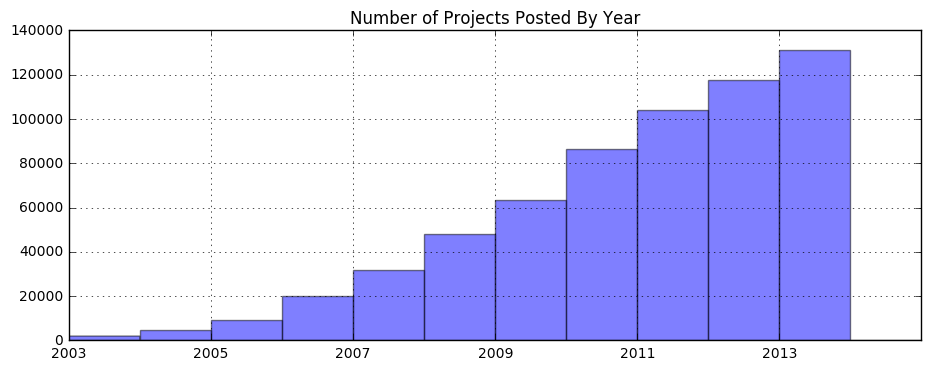

In [4]:
#Annual total postings
f, ax1 = plt.subplots(1, sharey=True,figsize = (11,4))
ax1 = testdf.datetime_posted.hist(bins = 12,\
                              range = (pd.datetime(2003,1,1),\
                                       pd.datetime(2014,12,31)), \
                              alpha = 0.5)
ax1.plot()
ax1.set_title("Number of Projects Posted By Year")


We are also give data on the prices of projects posted on the site.  Breaking out the stats on project prices, we see that the average project costs just over \$535, with the median falling around \$410.  This gap can be explained by outliers with extremely high prices, given that at least a some projects have prices in excess of $100,000.
*****************
* count    6.193260e+05
* mean     5.359818e+02
* std      1.312596e+04
* min      0.000000e+00
* 25%      2.670000e+02
* 50%      4.106600e+02
* 75%      5.803675e+02
* max      1.025002e+07

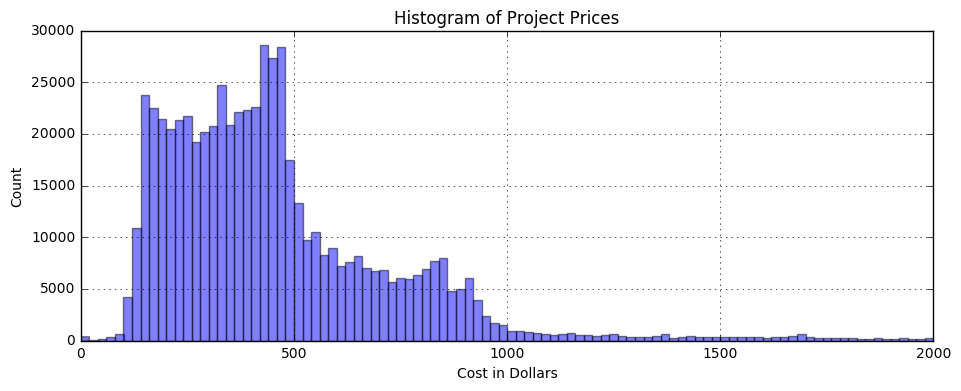

In [5]:
#Cost histograms w/ and w/o optional contributions
ax = testdf.total_price_excluding_optional_support.hist(bins=100, \
                                                     range = (0,2000),\
                                                     alpha = 0.5,figsize=(11,4))
ax.set_title("Histogram of Project Prices")
ax.set_xlabel("Cost in Dollars")
ax.set_ylabel("Count")

In addition, our dataset does include some information on the nature of donations given to individual projects.
************
* count    3.097989e+06
* mean     7.667692e+01
* std      2.704941e+02
* min      0.000000e+00
* 25%      1.000000e+01
* 50%      2.500000e+01
* 75%      5.611000e+01
* max      1.692000e+05
***************************
The majority of donations are well under \$100, but as with project prices, there are some large outliers that skew the data to the right.  

If we look closely at these donations with respect to time however, we see that the nature of donations has chaged as the site has grown.  The median donation size has droped from several hundred dollars in the early days of the platorm, to well below one hundred dollars now.  At the same time, the number of donations made using the site has seen massive grown in that same time frame.

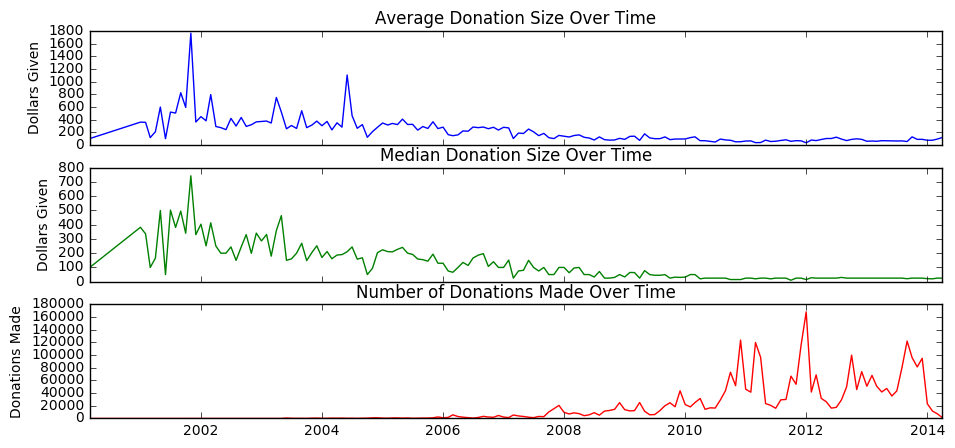

In [6]:
import datetime
donations['datetime'] = pd.to_datetime(donations['donation_timestamp'])
donations['year_month'] = donations['datetime'].apply(lambda x: datetime.datetime(x.year, x.month, 1))
groupby_year_month = donations['donation_total'].groupby(donations.year_month)

f, ax = plt.subplots(3, sharex=True,figsize = (11,5))
ax[0].plot(groupby_year_month.mean().sort_index())
ax[0].set_ylabel("Dollars Given")
ax[0].set_title("Average Donation Size Over Time")
ax[1].plot(groupby_year_month.median().sort_index(),color='g')
ax[1].set_ylabel("Dollars Given")
ax[1].set_title("Median Donation Size Over Time")
ax[2].plot(groupby_year_month.count().sort_index(),color='r')
ax[2].set_ylabel("Donations Made")
ax[2].set_title("Number of Donations Made Over Time")

Notably, the plot of donations made with respect to time appears to show a relatively cyclical pattern in recent years, which suggests that more money is likely flowing through the platform at different times of the year.  This will be the jumping off point for the next seciton.

## How Can Teachers Best Position Their Projects to Recieve Funding?

To delve into the ways in which what a teacher requests and how that request is made have an affect on the funding outcome of a given project, we first examine the likelihood of any given project being funded, broken down by the month and year in which the project was posted.  It is immediately clear from examining the graph that not all times of the year are created equal when it comes to attracting donors, and it seems as if there is a somewhat regular pattern wherein the lowest likelihoods of success fall right after the start of the new year.  Additionally, there is a reliable spike right around the start of the school year each fall.  

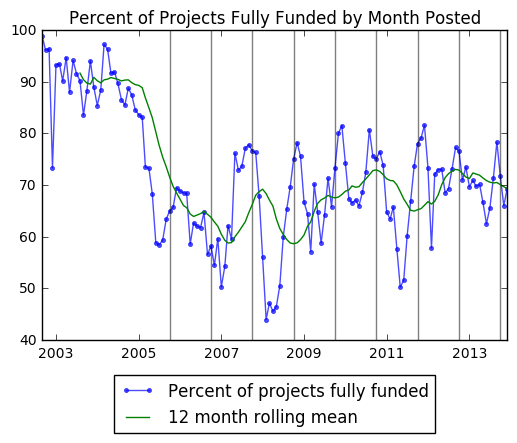

In [7]:
posted = pd.DataFrame()
posted['counts'] = testdf.year_month.value_counts()
posted['funded_count'] = testdf.loc[testdf['funded_bool'] == 1, 'year_month'].value_counts()
posted['percent_funded'] = posted.funded_count / posted.counts * 100
posted['month'] = posted.index.tolist()
posted['month_int'] = posted.month.astype(np.int64)
posted['zero'] = 0

posted = posted.sort('month')

#Overall percent of projects sucessfully funded by month posted
value_line = plt.plot_date(posted['month'],posted['percent_funded'],linestyle='solid',marker=".",\
              alpha = 0.7,label='Percent of projects fully funded')
plt.title('Percent of Projects Fully Funded by Month Posted')
plt.axvline('2013-10-01', 0, 1,color='k',alpha = 0.5)
plt.axvline('2012-10-01', 0, 1,color='k',alpha = 0.5)
plt.axvline('2011-10-01', 0, 1,color='k',alpha = 0.5)
plt.axvline('2010-10-01', 0, 1,color='k',alpha = 0.5)
plt.axvline('2009-10-01', 0, 1,color='k',alpha = 0.5)
plt.axvline('2008-10-01', 0, 1,color='k',alpha = 0.5)
plt.axvline('2007-10-01', 0, 1,color='k',alpha = 0.5)
plt.axvline('2006-10-01', 0, 1,color='k',alpha = 0.5)
plt.axvline('2005-10-01', 0, 1,color='k',alpha = 0.5)
mean_line = plt.plot(pd.rolling_mean(posted['percent_funded'],12),label='12 month rolling mean')
plt.legend(bbox_to_anchor=(0.5, -0.30), loc=8, borderaxespad=0.)

In the above plot, vertical lines are placed on October 1st of each year between 2005 and 2013.  Earlier years are excluded because they are not in general representative of the dataset's behavior in later years, and because the cyclical patter marked by the lines does not appear to develop in earnest until 2007.  This data strongly suggests that teachers stand to benefit from posting projects strategically to take advantage of greater opportunities for funding toward the end of each calendar year and the start of each school year.  However, it may simply be the case that donors are more willing to fund the sorts of projects that are posted towards the start of the school year.  For example, teachers may find themselves more in need of basic supplies when school starts, and donors could simply prefer funding school supplies as compared to projects that may be more prevelent at other times of the year.

F_onewayResult(statistic=37.264218535944444, pvalue=6.7061258687631352e-22)
Ttest_indResult(statistic=-4.6346709417436074, pvalue=5.570122774911006e-06)
Ttest_indResult(statistic=2.862190495980053, pvalue=0.0045367755498985727)
Ttest_indResult(statistic=4.7427437240062265, pvalue=3.4187059506142469e-06)
Ttest_indResult(statistic=-2.7629600629037059, pvalue=0.0061217042319055073)


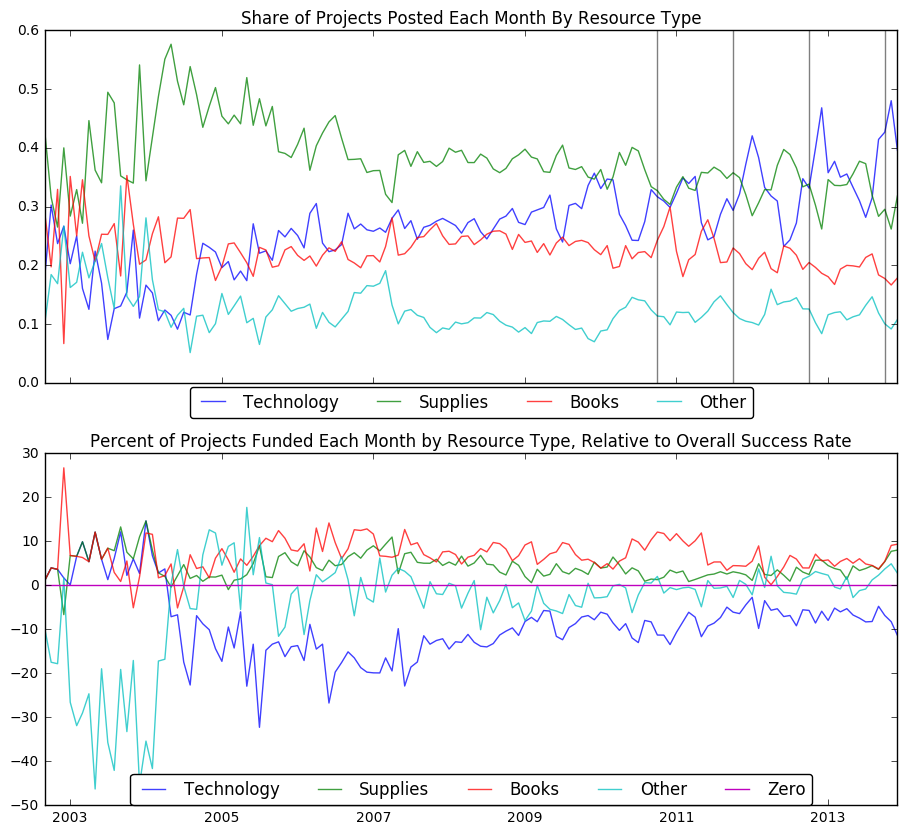

In [8]:
#Percent funded each month by resource type
posted['technology_count'] = testdf.loc[testdf['resource_type_int'] == 1, 'year_month'].value_counts()
posted['technology_funded'] = testdf.loc[(testdf['resource_type_int'] == 1) & \
                                         (testdf['funded_bool'] == 1), 'year_month'].value_counts()
posted['percent_technology_funded'] = posted.technology_funded / posted.technology_count * 100
posted['supplies_count'] = testdf.loc[testdf['resource_type_int'] == 2, 'year_month'].value_counts()
posted['supplies_funded'] = testdf.loc[(testdf['resource_type_int'] == 2) & \
                                       (testdf['funded_bool'] == 1), 'year_month'].value_counts()
posted['percent_supplies_funded'] = posted.supplies_funded / posted.supplies_count * 100
posted['books_count'] = testdf.loc[testdf['resource_type_int'] == 3, 'year_month'].value_counts()
posted['books_funded'] = testdf.loc[(testdf['resource_type_int'] == 3) & \
                                    (testdf['funded_bool'] == 1), 'year_month'].value_counts()
posted['percent_books_funded'] = posted.books_funded / posted.books_count * 100
posted['other_count'] = posted.counts-posted.technology_count-posted.supplies_count-posted.books_count
posted['other_funded'] = posted.funded_count-posted.technology_funded-posted.supplies_funded-posted.books_funded
posted['percent_other_funded'] = posted.other_funded / posted.other_count * 100

#Resource types' share of overall postings by month
posted['technology_share'] = posted.technology_count / posted.counts
posted['supplies_share'] = posted.supplies_count / posted.counts
posted['books_share'] = posted.books_count / posted.counts
posted['other_share'] = posted.other_count / posted.counts

#Relative likelyhood funded each month by resource type
posted['relative_technology_percent'] = posted.percent_technology_funded - posted.percent_funded
posted['relative_supplies_percent'] = posted.percent_supplies_funded - posted.percent_funded
posted['relative_books_percent'] = posted.percent_books_funded - posted.percent_funded
posted['relative_other_percent'] = posted.percent_other_funded - posted.percent_funded

f, ax = plt.subplots(2, sharex=True,figsize = (11,10))
ax[0].title.set_text('Share of Projects Posted Each Month By Resource Type')
ax[0].plot(posted.month,posted.technology_share,label='Technology',alpha = 0.75)
ax[0].plot(posted.month,posted.supplies_share,label='Supplies',alpha = 0.75)
ax[0].plot(posted.month,posted.books_share,label='Books',alpha = 0.75)
ax[0].plot(posted.month,posted.other_share,label='Other',alpha = 0.75)
ax[0].axvline('2013-10-01', 0, 1,color='k',alpha = 0.5)
ax[0].axvline('2012-10-01', 0, 1,color='k',alpha = 0.5)
ax[0].axvline('2011-10-01', 0, 1,color='k',alpha = 0.5)
ax[0].axvline('2010-10-01', 0, 1,color='k',alpha = 0.5)

ax[1].title.set_text('Percent of Projects Funded Each Month by Resource Type, Relative to Overall Success Rate')
ax[1].plot(posted.month,posted.relative_technology_percent,label='Technology',alpha = 0.75)
ax[1].plot(posted.month,posted.relative_supplies_percent,label='Supplies',alpha = 0.75)
ax[1].plot(posted.month,posted.relative_books_percent,label='Books',alpha = 0.75)
ax[1].plot(posted.month,posted.relative_other_percent,label='Other',alpha = 0.75)
ax[1].plot(posted.month,posted.zero,label='Zero')
first_legend = plt.legend(bbox_to_anchor=(0.5, 0.0), loc=8, borderaxespad=0.,ncol = 5, fancybox = True)
ax = plt.gca().add_artist(first_legend)
plt.legend(['Technology','Supplies','Books','Other'],bbox_to_anchor=(0.5, 1.1), loc=8,\
           borderaxespad=0.,ncol = 4, fancybox = True)

print(stats.stats.f_oneway(posted.percent_technology_funded,posted.percent_supplies_funded,posted.percent_books_funded,posted.percent_other_funded))
print(stats.ttest_ind(a=posted.percent_technology_funded,b=posted.percent_funded))
print(stats.ttest_ind(a=posted.percent_supplies_funded,b=posted.percent_funded))
print(stats.ttest_ind(a=posted.percent_books_funded,b=posted.percent_funded))
print(stats.ttest_ind(a=posted.percent_other_funded,b=posted.percent_funded))

The first of the two above plots suggests that some types of projects, and in particular technology projects, do have seasonal spikes in frequency that correspond with the tail end of the calendar year, and thus roughly matches the uptick in the percentage of projects fully funded around that time.  However, the second plot clarifies that the increase in technology related postings is unlikely to be directly related to that phenomenon.  Although the number of technology postings has spiked right around that time in recent years and has regularly been the most common sort of posting during that part of the year, technology projects have been significantly less likely to recieve funding than any other sort of project since at least 2005.  

If an increased likelhood of funding success cannot be explained by the types of projects being posted at different times of year, perhaps the total price of projects varies over time and program costs are more affordable, and therefore appealing to donors, at the start of the school year.  In considering this data, we will examine only costs exclusive of optional support, this both because optional support is not listed on the webpage when donors select a project to support, and thus is unlikely to influence their choice, but also because as shown below, the two values are so closely corrolated that either could reasonably be selected.



In [9]:
testdf[['total_price_excluding_optional_support','total_price_including_optional_support']].corr()

,total_price_excluding_optional_support,total_price_including_optional_support
total_price_excluding_optional_support,1.000000,0.999998
total_price_including_optional_support,0.999998,1.000000


To examine the relationship between project cost, funding, and time, we bucket project costs into seven \$250 increments, with all values above \$1500 being grouped together.  As demonstrated by the histogram above, the vast majority of projects will fall into one of the bounded buckets.  

In [10]:
#Numbers posted in each cost bracket by month
posted['0-250'] = testdf.loc[testdf['total_price_excluding_optional_support'] <= 250, 'year_month'].value_counts()
posted['250-500'] = testdf.loc[(testdf['total_price_excluding_optional_support'] <= 500) &\
                                (testdf['total_price_excluding_optional_support'] > 250), 'year_month'].value_counts()
posted['500-750'] = testdf.loc[(testdf['total_price_excluding_optional_support'] <= 750) &\
                                (testdf['total_price_excluding_optional_support'] > 500), 'year_month'].value_counts()
posted['750-1000'] = testdf.loc[(testdf['total_price_excluding_optional_support'] <= 1000) &\
                                (testdf['total_price_excluding_optional_support'] > 750), 'year_month'].value_counts()
posted['1000-1250'] = testdf.loc[(testdf['total_price_excluding_optional_support'] <= 1250) &\
                                (testdf['total_price_excluding_optional_support'] > 1000), 'year_month'].value_counts()
posted['1250-1500'] = testdf.loc[(testdf['total_price_excluding_optional_support'] <= 1500) &\
                                (testdf['total_price_excluding_optional_support'] > 1250), 'year_month'].value_counts()
posted['>1500'] = testdf.loc[testdf['total_price_excluding_optional_support'] > 1500, 'year_month'].value_counts()

#Share of projects posted each month by cost
posted['0-250_share'] = posted['0-250'] / posted.counts
posted['250-500_share'] = posted['250-500'] / posted.counts
posted['500-750_share'] = posted['500-750'] / posted.counts
posted['750-1000_share'] = posted['750-1000'] / posted.counts
posted['1000-1250_share'] = posted['1000-1250'] / posted.counts
posted['1250-1500_share'] = posted['1250-1500'] / posted.counts
posted['>1500_share'] = posted['>1500'] / posted.counts

#Number funded in each cost bracket by month
posted['0-250_funded'] = testdf.loc[(testdf['total_price_excluding_optional_support'] <= 250) &\
                                           (testdf['funded_bool'] == 1), 'year_month'].value_counts()
posted['250-500_funded'] = testdf.loc[(testdf['total_price_excluding_optional_support'] <= 500) &\
                                    (testdf['total_price_excluding_optional_support'] > 250) &\
                                           (testdf['funded_bool'] == 1), 'year_month'].value_counts()
posted['500-750_funded'] = testdf.loc[(testdf['total_price_excluding_optional_support'] <= 750) &\
                                    (testdf['total_price_excluding_optional_support'] > 500) &\
                                           (testdf['funded_bool'] == 1), 'year_month'].value_counts()                                           
posted['750-1000_funded'] = testdf.loc[(testdf['total_price_excluding_optional_support'] <= 1000) &\
                                    (testdf['total_price_excluding_optional_support'] > 750) &\
                                           (testdf['funded_bool'] == 1), 'year_month'].value_counts()
posted['1000-1250_funded'] = testdf.loc[(testdf['total_price_excluding_optional_support'] <= 1250) &\
                                    (testdf['total_price_excluding_optional_support'] > 1000) &\
                                           (testdf['funded_bool'] == 1), 'year_month'].value_counts()
posted['1250-1500_funded'] = testdf.loc[(testdf['total_price_excluding_optional_support'] <= 1500) &\
                                    (testdf['total_price_excluding_optional_support'] > 1250) &\
                                           (testdf['funded_bool'] == 1), 'year_month'].value_counts()                                         
posted['>1500_funded'] = testdf.loc[(testdf['total_price_excluding_optional_support'] > 1500) &\
                                           (testdf['funded_bool'] == 1), 'year_month'].value_counts()

#Percent funded in each cost bracket by month
posted['percent_0-250_funded'] = posted['0-250_funded'] / posted['0-250'] * 100 
posted['percent_250-500_funded'] = posted['250-500_funded'] / posted['250-500'] * 100 
posted['percent_500-750_funded'] = posted['500-750_funded'] / posted['500-750'] * 100 
posted['percent_750-1000_funded'] = posted['750-1000_funded'] / posted['750-1000'] * 100 
posted['percent_1000-1250_funded'] = posted['1000-1250_funded'] / posted['1000-1250'] * 100 
posted['percent_1250-1500_funded'] = posted['1250-1500_funded'] / posted['1250-1500'] * 100 
posted['percent_>1500_funded'] = posted['>1500_funded'] / posted['>1500'] * 100 
                          
#Relative likelyhood funded each month by project cost
posted['relative_0-250_percent'] = posted['percent_0-250_funded'] - posted['percent_funded']                                          
posted['relative_250-500_percent'] = posted['percent_250-500_funded'] - posted['percent_funded']
posted['relative_500-750_percent'] = posted['percent_500-750_funded'] - posted['percent_funded']  
posted['relative_750-1000_percent'] = posted['percent_750-1000_funded'] - posted['percent_funded']  
posted['relative_1000-1250_percent'] = posted['percent_1000-1250_funded'] - posted['percent_funded']  
posted['relative_1250-1500_percent'] = posted['percent_1250-1500_funded'] - posted['percent_funded']  
posted['relative_>1500_percent'] = posted['percent_>1500_funded'] - posted['percent_funded']  

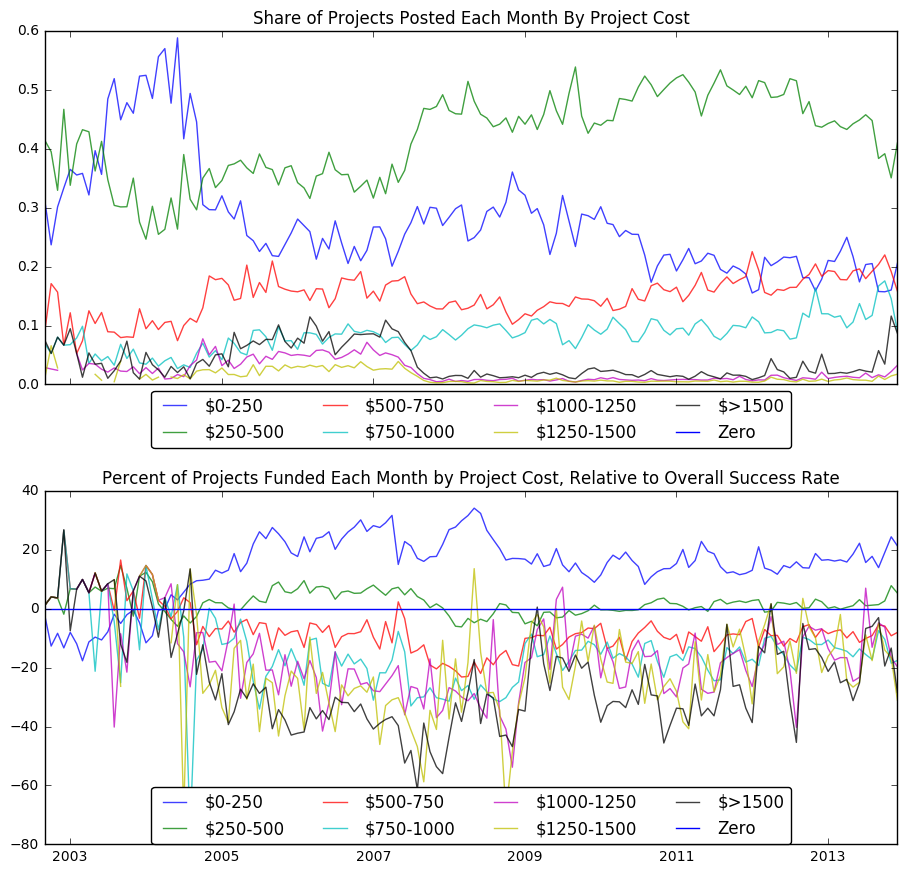

In [11]:
#Plot number of projects posted each month by project cost as portion of all posted 
f, ax = plt.subplots(2, sharex=True,figsize = (11,10.5))
ax[0].title.set_text('Share of Projects Posted Each Month By Project Cost')
ax[0].plot(posted.month,posted['0-250_share'],label='$0-250',alpha = 0.75)
ax[0].plot(posted.month,posted['250-500_share'],label='$250-500',alpha = 0.75)
ax[0].plot(posted.month,posted['500-750_share'],label='$500-750',alpha = 0.75)
ax[0].plot(posted.month,posted['750-1000_share'],label='$750-1000',alpha = 0.75)
ax[0].plot(posted.month,posted['1000-1250_share'],label='$1000-1250',alpha = 0.75)
ax[0].plot(posted.month,posted['1250-1500_share'],label='$1250-1500',alpha = 0.75)
ax[0].plot(posted.month,posted['>1500_share'],label='$>1500',alpha = 0.75)
        
#Plot likelyhood relative to overall rate of being funded by project cost
ax[1].title.set_text('Percent of Projects Funded Each Month by Project Cost, Relative to Overall Success Rate')
ax[1].plot(posted.month,posted['relative_0-250_percent'],label='$0-250',alpha = 0.75)
ax[1].plot(posted.month,posted['relative_250-500_percent'],label='$250-500',alpha = 0.75)
ax[1].plot(posted.month,posted['relative_500-750_percent'],label='$500-750',alpha = 0.75)
ax[1].plot(posted.month,posted['relative_750-1000_percent'],label='$750-1000',alpha = 0.75)
ax[1].plot(posted.month,posted['relative_1000-1250_percent'],label='$1000-1250',alpha = 0.75)
ax[1].plot(posted.month,posted['relative_1250-1500_percent'],label='$1250-1500',alpha = 0.75)
ax[1].plot(posted.month,posted['relative_>1500_percent'],label='$>1500',alpha = 0.75)
ax[1].plot(posted.month,posted.zero,label='Zero')
first_legend = plt.legend(bbox_to_anchor=(0.5, 0.0), loc=8, borderaxespad=0.,ncol = 4, fancybox = True)
ax = plt.gca().add_artist(first_legend)
plt.legend(bbox_to_anchor=(0.5, 1.12), loc=8,\
           borderaxespad=0.,ncol = 4, fancybox = True)
plt.subplots_adjust(hspace=0.3)

The breakdown of share and funding success of projects over time by price suggest that price has limited impact over the funding potential of a project with respect to its variance in time.  Funding does however clearly impact the likelihood that a project is fully funded, with cheaper projects proving intuitively over time to be easier to securing funding for.  Having briefly discussed the relationships between posting time, resource type, project cost, and whether or not a project is fully funded,  

In [16]:
from sklearn import preprocessing

#Numbers posted in each cost bracket by month
testdf['binned_price'] = np.zeros(testdf['total_price_excluding_optional_support'].size)
testdf.loc[testdf['total_price_excluding_optional_support'] <= 250, 'binned_price'] = 1
testdf.loc[(testdf['total_price_excluding_optional_support'] <= 500) &\
           (testdf['total_price_excluding_optional_support'] > 250), 'binned_price'] = 2
testdf.loc[(testdf['total_price_excluding_optional_support'] <= 750) &\
           (testdf['total_price_excluding_optional_support'] > 500), 'binned_price'] = 3
testdf.loc[(testdf['total_price_excluding_optional_support'] <= 1000) &\
           (testdf['total_price_excluding_optional_support'] > 750), 'binned_price'] = 4
testdf.loc[(testdf['total_price_excluding_optional_support'] <= 1250) &\
           (testdf['total_price_excluding_optional_support'] > 1000), 'binned_price'] = 5
testdf.loc[(testdf['total_price_excluding_optional_support'] <= 1500) &\
           (testdf['total_price_excluding_optional_support'] > 1250), 'binned_price'] = 6
testdf.loc[testdf['total_price_excluding_optional_support'] > 1500, 'binned_price'] = 7

resource_dummies = pd.get_dummies(testdf.resource_type_int, prefix='resource').iloc[:, 1:]
testdf = pd.concat([testdf, resource_dummies], axis=1)
price_dummies = pd.get_dummies(testdf.binned_price, prefix='price').iloc[:, 0:]
testdf = pd.concat([testdf, price_dummies], axis=1)

y = testdf.funded_bool
x = [testdf.year_month.astype(np.int64),testdf.binned_price,testdf.resource_type_int]
ones = np.ones(len(x[0]))
X = sm.add_constant(np.column_stack((x[0], ones)))
for ele in x[1:]:
    X = sm.add_constant(np.column_stack((ele, X)))
X_scale = preprocessing.robust_scale(X)
model = sm.OLS(y, X_scale)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            funded_bool   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                 1.058e+04
Date:                Tue, 08 Nov 2016   Prob (F-statistic):               0.00
Time:                        14:14:35   Log-Likelihood:            -7.5082e+05
No. Observations:              619326   AIC:                         1.502e+06
Df Residuals:                  619323   BIC:                         1.502e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.2332      0.002    110.271      0.0

This would suggest that a teacher seeking to improve the likelihood of their project being fully funded should take into account when they post their project, what category of funding they're asking for, and how much much money they're asking for.  Of these, although each variable does have an impact on funding rates, properly timing when to post the project is the most important consideration that a teacher can exercise clear control over.  

## Further Questions

Given the opportunity, I would ask Donor's Choose for any data describing how the site itself has changed over time.  The differences in much of the data before and after roughly 2005 suggest that either the userbase of the site shifted significantly during that time, or that the site implemented some changes in how it presents projects or what sorts of projects may be (explicitly or implicitly) encourage.  In fact, it is unlikely that the site has existed for this long without undergoing any sort of change in how it presents itself and the projects it hosts to donors, and such a change could have had an affect on many different datapoints.  

In a similar vein, it might be easier to make predictions about which sorts of projects will be funded if more data were provided about individual donors.  Currently the only data that is provided for each donor is a physical location (through zip codes), and whether or not they are a teacher, as well as any information that can be gleaned by examining their donations in aggregate.  Data on donors' educaiton levels, whether they have children in school, general demographics, etc. would make it easier to paint a more complete picture of the site's userbase and thereby make better predictions about the actions of that userbase.

Lastly, I would have appreciated some increased granularity in the categorical variables, specifically with reference to the resource_type variable.  A category like technology encompases everything from purchasing a class printer to buying every student in the class an ipad, and these represent very differnt sorts of projects that donors may look upon differently even beyond their wide price differential.  